# Creating a TensorFlow Model

In [21]:
from PIL import Image

### Questions / Errors

How do you rerun layer after already creating the tensorflow layer object without restarting kernel?


Below does not work:

    tf.reset_default_graph() 
    tf.keras.backend.clear_session()
    keras.backend.clear_session()

Some related links:

    https://github.com/tensorflow/tensorflow/issues/14356
    https://github.com/krshrimali/simple-keras-rest-api/commit/524ce2654613aeeac2b0b4912b2af0fa6b5f6023
    
Possible Solution 1:
    
    def load_model():
        global model
        model = ResNet50(weights="imagenet")
                # this is key : save the graph after loading the model
        global graph
        graph = tf.get_default_graph()
    
    # While predicting, use the same graph
    with graph.as_default():
        preds = model.predict(image)
        #... etc
        
Possible Solution 2:

    from keras import backend as K
    
    # After predicting the data, insert code
    K.clear_session()

---------

### 1. Loading Data

The first step of training a machine learning algorithm is loading the training data. 
- Preload data into memory
    - The simplest method is to preload all your data into memory and pass it to TensorFlow as a single array
    - Simply __read your data file into an array__ to TensorFlow (size up to computer's available memory)
    - As long as the data ends up in a multidimensional array then you're good
        - Using pandas and preprocessing the data
    
    
- Feed data step by step
    - Write code that feeds your training data step-by-step into TensorFlow as TensorFlow requests it 
    - TensorFlow calls the data loader function whenever it needs the next chunk of data which gives you more control
    - Easier to process large datasets since it loads one chunk at a time
    - Have to write all of the code yourself
    
    
- Set up a custom data pipeline
    - This is the best option when you are working with enormous datasets like millions of images. A data pipeline allows TensorFlow to manage loading data into memory itself as it needs it
    - Data pipeline only loads data into memory in small chunks which means that it can work with large datasets
    - Requires writing TensorFlow-specific code
    - Big advantage of building a data pipeline is that you can take advantage of __parallel processing__ across multiple CPUs
    - Can have several threads running at the same time to load and preprocess data
    - Training process doesn't have to stop and wait while the next chunk of data is loaded for the next training pass

### Data Pipeline Example

Let's say our dataset is made up of hundreds of separate CSV files. 
1. The first step is to create a list of all the file names of the data files that need to be processed. 


2. Next, we shuffle the file names into a random order and add the file names into a file processing queue. 


3. Next, individual file names will be pulled out of the file processing queue and sent to the CSV file reader. The CSV reader will parse the raw data out of the CSV file and break it up into individual records. 


4. From there, each record in the CSV file is fed into the record decoder. The record decoder pulls out and formats the individual values from each record. 


5. And finally, we'll queue up each record in the data queue where it's ready to be fed into your neural network for training. 

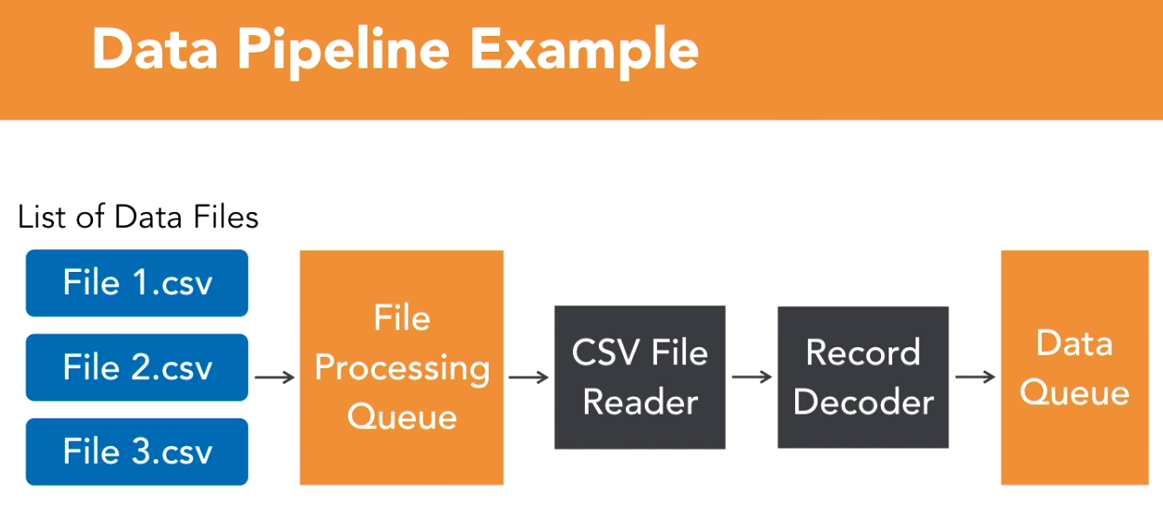

In [22]:
Image.open('Images/04-data-pipeline.png')

TensorFlow provides functions and helpers to help you build each step of this pipeline, and once you've built the pipeline, TensorFlow will execute it for you.

### Recommendations

Choose the simplest solution that works for your project

- If your dataset fits in the memory, preload the entire dataset. It require the least amount of code
- But if your dataset is huge, then set up a data pipeline. It's the most efficient way to work with large datasets 
    - Data pipelines are especially common for image-based datasets since images take up a lot of the memory
- Just think of building a data pipeline as additional complexity you only need to add if other solutions won't work

----------

## Predict Video Game Sales

### (Preprocess): Load data, scale, and save

In [23]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load training data set from CSV file
training_data_df = pd.read_csv("Data/sales_data_training.csv")

# Load testing data set from CSV file
test_data_df = pd.read_csv("Data/sales_data_test.csv")

# Data needs to be scaled to a small range like 0 to 1 for the neural
# network to work well.
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale both the training inputs and outputs
scaled_training = scaler.fit_transform(training_data_df)
scaled_testing = scaler.transform(test_data_df)

# Print out the adjustment that the scaler applied to the total_earnings column of data
print("Note: total_earnings values were scaled by multiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[8], scaler.min_[8]))

# Create new pandas DataFrame objects from the scaled data
scaled_training_df = pd.DataFrame(scaled_training, columns=training_data_df.columns.values)
scaled_testing_df = pd.DataFrame(scaled_testing, columns=test_data_df.columns.values)

# # Save scaled data dataframes to new CSV files
# scaled_training_df.to_csv("sales_data_training_scaled.csv", index=False)
# scaled_testing_df.to_csv("sales_data_testing_scaled.csv", index=False)

Note: total_earnings values were scaled by multiplying by 0.0000036968 and adding -0.115913


### 1. Load the data

In [24]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Clear session
tf.keras.backend.clear_session()

# Load the training data
training_data_df = pd.read_csv('Data/sales_data_training.csv', dtype=float) # expect float-point numbers

# Get X and Y data
X_training = training_data_df.drop('total_earnings', axis=1).values # call .values to get back the result as an array
Y_training = training_data_df[['total_earnings']].values

# Load testing data
test_data_df = pd.read_csv('Data/sales_data_test.csv', dtype=float) # expect float-point numbers

# Get X and y test data
X_testing = test_data_df.drop('total_earnings', axis=1).values # .values for array
Y_testing = test_data_df[['total_earnings']].values

# Preprocess data
X_scaler = MinMaxScaler(feature_range=(0,1))
Y_scaler = MinMaxScaler(feature_range=(0,1))

''' 
  The scaler scales the data by multiplying it by a constant number and adding a constant number.
'''

# Scale the data using scaler
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

# Scale testing
X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

# Print shape
print(X_scaled_testing.shape)
print(Y_scaled_testing.shape)

print('Note: Y values were scaled by multiplying by {:.10f} and adding {:4f}'.format(Y_scaler.scale_[0], Y_scaler.min_[0]))

(400, 9)
(400, 1)
Note: Y values were scaled by multiplying by 0.0000036968 and adding -0.115913


### Steps in loading so far
1. Get training data from CSV files
2. Get X & Y features
3. Preprocess the data using the training dataset using - MinMaxScaler()
4. Scale the training data using - fit_transform()
5. Scale the testing data using - transform()

### 2. Define the Model Structure

Build a neural network with TensorFlow with 9 input features so we'll need nine inputs in our neural network. We need to model that with a placeholder called X that holds nine values.

Then, we will also have three layers in the neural network that will train to find the relationship between the inputs and the output. There are many types of layers that we can use. For this example, we will use the most straightforward type, a __fully connected neural network layer__.

That means that every node in each layer is connected to every node in the following layer. 
1. The first layer will have 50 nodes
2. The second layer will have 100 nodes
3. The third layer will have 50 nodes

These layer sizes represent a starting point and is just a guess on the sizes. Once the neural network is coded, we can test out the different layer sizes to see what layer size gives us the best accuracy. The output layer will have just one node since we are trying to predict a single value.

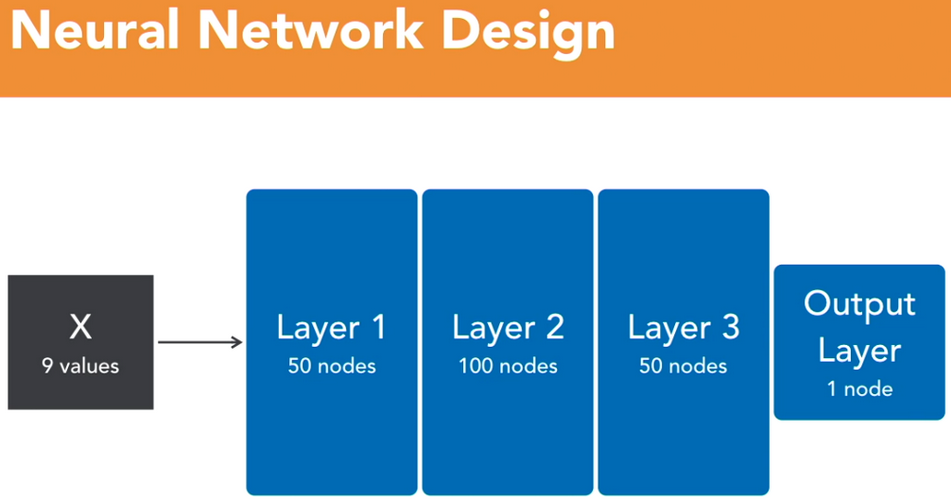

In [25]:
Image.open('Images/05-design.png')

## Section Zero: Define parameters and nodes

### Define model parameters

In [26]:
# Define model parameters
learning_rate = 0.001
learning_epochs = 100
display_step = 5

In [27]:
# Define how many inputs and outputs are in our neural network
number_of_inputs = 9
number_of_outputs = 1

### Define how many neurons we want in each layer of our neural network

In [28]:
# Define how many neurons we want in each layer of our neural network
layer_1_nodes = 50
layer_2_nodes = 100
layer_3_nodes = 50

## Section One: Define the layers of the neural network itself

To keep things organized it's helpful to put each layer of our neural network in its own variable scope. Normally in Python we organize our code by creating new functions. In TensorFlow we can create __variable scopes__ by using the __tf.variablescope__ function instead. 

    ** Any variables we create within this scope will automatically get a prefix of input to their name internally in TensorFlow

TensorFlow has the ability to generate diagrams of the computational graph. By putting our nodes into scopes it helps TensorFlow generate more useful diagrams that are easier to understand. Everything within the same scope will be grouped together within the diagram. 

Our neural network should accept nine floating point numbers as the input for making predictions. But each time we want a new prediction the specific values we pass in will be different. So we can use a __placeholder node__ to represent that. 

### Input Layer

Create a tf.placeholder object with data type, size, shape
- When we create a new node we need to tell it what type of tensor it will accept. The data we are passing into our network will be floating point numbers so we'll tell it to inspect the tf.float32 object.


- For the shape of the input, we use "None", number_of_inputs
    - "None" tells TensorFlow our neural network can mix up batches of any size and number_of_inputs tells it to expect nine values for each record in the batch

In [29]:
# Define input layer (new variable scope)
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, shape=(None, number_of_inputs))

### Layer 1

A fully connected layer of the neural network has three parts.
1. A weight value for each connection between each node and the nodes in the previous layer
2. A bias value for each node
3. An activation function that outputs the result of the layer

We need a bias value for each node, and an activation function that outputs the result of the layer.

#### Biases
First, we need variables to store the bias values for each node.  This will be a variable instead of a placeholder because we want TensorFlow to remember the value over time. 

To create a variable we can call __tf.getvariable__ and pass in the name.

Next, we need to pass in the shape of this variable. There's one bias value for each node in this layer, so the shape should be the same as the number of nodes in the layer. We define that above as Layer_1_nodes.

So we'll say shape equal, and then we'll pass in the size as Layer_1_nodes. 

We also need to tell TensorFlow the initial value of this variable. We can tell TensorFlow how to set the initial value of a variable by passing it one of __TensorFlow's built-in initializer functions__. 

We want the bias values for each node to default to zero, so I'll pass in the inititalizer function of tf.zeros_initializer as the initializer to use. So we'll pass in initializer equal, and pass in __tf.zeros_initializer__. 

#### Weights
We'll pass in the name weight1. 

We also need to give this variable a shape. This part's a little tricky. We want to have one weight for each node's connection to each node in the previous layer. So we can define the shape like this. We'll say shape equals, and as an array, one side of the array will be number of inputs, and the other side will be layer_1_nodes. 

And finally, we need to set the variable initializer. With neural networks, a lot of research has gone into the best initial values to use for weights. A good choice is an algorithm called Xavier initialization. TensorFlow has a built-in xavier_initializer function so we can use that. So we'll pass in initializer equal __tf.contrib.layers.xavier_initializer()__. 

#### Layer_1_Output
The last part of defining this layer is multiplying the weights by the inputs and calling an activation function. TensorFlow is very flexible here and let's you do this in any way you want. 

We're going to use matrix multiplication and a standard rectified linear unit or relu activation function. We can do this by first calling __tf.matmul for matrix multiplication__. And we'll multiply the inputs, X, by the weights in this layer. To that we'll add the biases, and we'll wrap that with a call to the __relu function. Tf.nn.relu__. 

If you're not familiar with the math behind neural networks, this might not be familiar to you, but this is how you define the standard fully-connected neural network. 

### [Initializers Documentation](https://www.tensorflow.org/guide/variables)

tf.contrib.layers.xavier_initializer - https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer

    Returns an initializer performing "Xavier" initialization for weights
    
This initializer is designed to keep the scale of the gradients roughly the same in all layers. 
    
In uniform distribution this ends up being the range: 
    
    x = sqrt(6. / (in + out)); [-x, x] 
    
and for normal distribution a standard deviation of 
    
    sqrt(2. / (in + out)) is used.

__Returns__: An initializer for a weight matrix.


In [30]:
# Layer 1
with tf.variable_scope('layer_1'): # reuse=True or reuse=tf.AUTO_REUSE
    weights = tf.get_variable(name="weights1", shape=[number_of_inputs, layer_1_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases1", shape=[layer_1_nodes], initializer=tf.zeros_initializer())
    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)
    
"""
  Set the parameter initialization using the method described.

  This method is designed to keep the scale of the gradients roughly the same
  in all layers.
  
  Xavier Glorot and Yoshua Bengio (2010):
           Understanding the difficulty of training deep feedforward neural
           networks. International conference on artificial intelligence and
           statistics.
  Args:
    n_inputs: The number of input nodes into each output.
    n_outputs: The number of output nodes for each input.
    uniform: If true use a uniform distribution, otherwise use a normal.
    
  Returns:
    An initializer.
"""

### Layer 2

In [31]:
# Layer 2
with tf.variable_scope('layer_2'):
    weights = tf.get_variable(name="weights2", shape=[layer_1_nodes, layer_2_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases2", shape=[layer_2_nodes], initializer=tf.zeros_initializer())
    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

### Layer 3

In [36]:
# Layer 3
with tf.variable_scope('layer_3'):
    weights = tf.get_variable(name="weights3", shape=[layer_2_nodes, layer_3_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases3", shape=[layer_3_nodes], initializer=tf.zeros_initializer())
    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

### Output Layer

In [37]:
# Output Layer
with tf.variable_scope('output'):
    weights = tf.get_variable(name="weights4", shape=[layer_3_nodes, number_of_outputs], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases4", shape=[number_of_outputs], initializer=tf.zeros_initializer())
    prediction = tf.matmul(layer_3_output, weights) + biases

## Section Two: Define the cost function of the neural network that will measure prediction accuracy during training

To be able to train it we need a cost function. A cost function, also called a __lost function__ tells us how wrong the neural network is when trying to predict the correct output for a single piece of training data. 

Define Y, a node for the expected value that we'll feed in during training. Just like the input values it will be a placeholder node because we'll feed in a new value each time. So we'll create a tf.placeholder node. The type will be floating point again, so we'll use tf.float32. 

And for the shape in this case we'll pass in None, 1 since there's just one single output. Shape equals None, 1. 

Next we need to calculate the cost. To measure the cost we'll calculate the mean squared error between what the neural network predicted and what we expected it to calculate. To do that we'll call the __tf.squared_difference__ function and pass in the actual predication and the expected value. So tf.squared_difference, and we'll pass in our prediction which we defined above. 

And our expected value, which is Y. That will give us the square difference. To turn it into a mean square difference, we want to get the average value of that difference. So we'll wrap that with a call to the reduce_mean function which will do that for us. So we'll wrap that with a call to __tf.reduce_mean__. 

In [39]:
# Define the cost function of the neural network
with tf.variable_scope('cost'):
    Y = tf.placeholder(tf.float32, shape=(None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))

## Section Three: Define the optimizer function that will be run to optimize the neural network

The very last step is to create an optimizer operation that TensorFlow can call to train the network. 

To define an optimizer, we just need to call one of the optimizers supplied by TensorFlow. One of the standard optimizers that's very powerful is called the Adam optimizer. To use it just call __tf.train.AdamOptimizer__. 

We just need to pass in the learning rate which we've already pre-defined above. Next, we need to tell it which variable we want it to minimize. So we'll pass in our cost function as the value to minimize call. So we'll call __.minimize__, and we'll pass in cost. That tells TensorFlow that whenever we tell it to execute the optimizer, it should run one iteration of the Adam optimizer in an attempt to make the cost value smaller. 

And that's it, now our neural network is fully defined. 

In [40]:
# Define the optimizer function
with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Initialize a training session after defining the model

Once you have loaded your data set and defined your model, you're ready to create a training loop to train the model. 

An epoch is another name for one full training pass over the training data set. When epoch = 100, this means we will do 100 iterations in our training loop to train our neural network.

For session.run, the first command we always run is the built in command to tell TensorFlow to initialize all variables in our graph to their default values. The command that's called tf.global_variables_initializer. Now that all the variables in our graph are initialized, we're ready to create our training loop. 

In [42]:
# Initialize a session so that we can run TensorFlow operations
with tf.Session() as session:
    
    # Run the global variable initializer to initialize all variables and layers of the neural network
    session.run(tf.global_variables_initializer()) # execute commands by calling session.run & pass in global initializer
    
    # Run the optimizer over and over to train the network.
    # One epoch is one full run through the training data set.
    for epoch in range(2):
    
        # Feed in the training data and do one step of neural network training    
        session.run(optimizer, feed_dict={X: X_scaled_training, Y: Y_scaled_training}) # pass in operation
        
#         # Print the current training status to the screen
#         print('Training pass: {}'.format(epoch))
        
        # Every 5 training steps, log progress
        if epoch % 5 == 0:
            training_cost = session.run(cost, feed_dict={X: X_scaled_training, Y: Y_scaled_training})
            testing_cost = session.run(cost, feed_dict={X: X_scaled_testing, Y: Y_scaled_testing})
            print(epoch, training_cost, testing_cost)
        
    # Training is now complete!      
    print('Training is now complete!')
    
    final_training_cost = session.run(cost, feed_dict={X: X_scaled_training, Y: Y_scaled_training})
    final_testing_cost = session.run(cost, feed_dict={X: X_scaled_testing, Y: Y_scaled_testing})
    
    print('Final Training cost: {}'.format(final_training_cost))
    print('Final testing cost: {}'.format(final_testing_cost))

Training pass: 0
Training pass: 1
Training is now complete!


## Model Logging

In TensorFlow, we log values by creating special operations in our graph called summary operations. These operations take in the value and create log data in a format that TensorBoard can understand. 

Then, we pass that summary data to a TensorFlow file writer object to save it to disk.

**Single Metric**

1. For the logging variable scope, we will add a scaler object that will represent the value we are logging.
2. Why tf.summary.scaler() object?
    - A scaler is just a single number so that's what you want to use to log a single value like this
    - TensorFlow supports logging more complex objects like histograms, pictures, and even sound files
3. Run the logging node in session.run()

**Multiple Metrics Solution**
4. While running this node directly is easy when you only have one metric, sometimes you'll want to log many different metrics. It can be tedious to have to call session.run on every single metric so TensorFlow has a shortcut. 
    - We're going to define a new node of type __tf.summary.merge_all__ 

In [ ]:
# After optimizer variable we create a logging variable

# Create a summary operation to log the progress of the network (variable to hold logging operations)
with tf.variable_scope('logging'): 
    tf.summary.scaler(name='current_cost', cost) # add scaler object that will represent the value we are logging
    
    '''Execute all sumary nodes in your graph without explicitly listing them all'''
    
    summary = tf.summary.merge_all() # helper function
    
# Initialize a session so that we can run TensorFlow operations
with tf.Session() as session:
    
    # Run the global variable initializer to initialize all variables and layers of the neural network
    session.run(tf.global_variables_initializer()) # execute commands by calling session.run & pass in global initializer
    
    # Run the optimizer over and over to train the network.
    # One epoch is one full run through the training data set.
    for epoch in range(100):
    
        # Feed in the training data and do one step of neural network training    
        session.run(optimizer, feed_dict={X: X_scaled_training, Y: Y_scaled_training}) # pass in operation
        
#         # Print the current training status to the screen
#         print('Training pass: {}'.format(epoch))
        
        # Every 5 training steps, log progress
        if epoch % 5 == 0:
            
            '''
              Second part was to create an array from cost to [cost, summary] # runs two operations
              
              Add training_summary and testing_summary
            '''
            
            # Get current accuracy scores by running the cost operation
            training_cost, training_summary = session.run([cost , summary], feed_dict={X: X_scaled_training, Y: Y_scaled_training})
            testing_cost, testing_summary = session.run([cost , summary], feed_dict={X: X_scaled_testing, Y: Y_scaled_testing})
            print(epoch, training_cost, testing_cost)
            
            '''
              Add the summary operation to our computational graph that will log the cost
            '''
            
            # Write the current training status to the log files; separate train and test log files
            training_writer = tf.summary.FileWriter('./logs/training', session.graph)
            testing_writer = tf.summary.FileWriter('.logs/testing', session.graph)
            
    # Training is now complete!      
    print('Training is now complete!')
    
    final_training_cost = session.run(cost, feed_dict={X: X_scaled_training, Y: Y_scaled_training})
    final_testing_cost = session.run(cost, feed_dict={X: X_scaled_testing, Y: Y_scaled_testing})
    
    print('Final Training cost: {}'.format(final_training_cost))
    print('Final testing cost: {}'.format(final_testing_cost))